In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import joblib

In [2]:
# 1. 데이터 로드 및 전처리
print("데이터 로딩 중")
data = pd.read_csv('price data.csv', sep=',')

# 데이터 확인
print("\n데이터 정보:")
print(data.info())
print("\n기초 통계량:")
print(data.describe())

데이터 로딩 중

데이터 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1940 entries, 0 to 1939
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      1940 non-null   int64  
 1   avgTemp   1940 non-null   float64
 2   minTemp   1940 non-null   float64
 3   maxTemp   1940 non-null   float64
 4   rainFall  1940 non-null   float64
 5   avgPrice  1940 non-null   int64  
dtypes: float64(4), int64(2)
memory usage: 91.1 KB
None

기초 통계량:
               year      avgTemp      minTemp      maxTemp     rainFall  \
count  1.940000e+03  1940.000000  1940.000000  1940.000000  1940.000000   
mean   2.018972e+07     9.093505     2.915412    16.255825     2.316701   
std    3.310322e+04    10.116631    10.609528    10.420466     7.976453   
min    2.013110e+07   -12.900000   -19.500000    -7.800000     0.000000   
25%    2.016022e+07     1.000000    -5.100000     7.300000     0.000000   
50%    2.019122e+07     7.450000     0.600000    

In [3]:
# 특성과 타겟 분리
X = data[['avgTemp', 'minTemp', 'maxTemp', 'rainFall']].to_numpy()
y = data[['avgPrice']].to_numpy()

# 데이터 타입 설정
X = X.astype(np.float64)
y = y.astype(np.float64)

In [4]:
# 2. 데이터 분할 (학습용 80%, 테스트용 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# 3. 정규화
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

In [6]:
# 4. 모델 구성 - 선형 회귀 모델
# 가중치와 편향 초기화
initializer = tf.keras.initializers.GlorotUniform()
W = tf.Variable(initializer([4, 1], dtype=tf.float64), name="weight")
b = tf.Variable(tf.zeros([1], dtype=tf.float64), name="bias")

In [7]:
# 가설 함수
def hypothesis(X):
    return tf.matmul(X, W) + b

In [8]:
# 손실 함수
def cost_fn(X, Y):
    predictions = hypothesis(X)
    return tf.reduce_mean(tf.square(predictions - Y))

In [9]:
# 옵티마이저
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [10]:
# 5. 학습
print("\n학습 시작")
EPOCHS = 10000
train_losses = []
test_losses = []

for step in range(EPOCHS):
    # 학습 단계
    with tf.GradientTape() as tape:
        train_loss = cost_fn(X_train_scaled, y_train_scaled)
    
    gradients = tape.gradient(train_loss, [W, b])
    optimizer.apply_gradients(zip(gradients, [W, b]))
    
    # 테스트 손실 계산
    test_loss = cost_fn(X_test_scaled, y_test_scaled)
    
    # 손실 기록
    train_losses.append(train_loss.numpy())
    test_losses.append(test_loss.numpy())
    
    # 진행 상황 출력
    if step % 500 == 0:
        # 실제 스케일로 예측값 계산
        train_pred_scaled = hypothesis(X_train_scaled).numpy()
        train_pred = scaler_y.inverse_transform(train_pred_scaled)
        
        print(f"Step {step}/{EPOCHS}")
        print(f"  Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
        print(f"  Sample Prediction: {train_pred[0][0]:.2f}원")


학습 시작
Step 0/10000
  Train Loss: 9.0569, Test Loss: 7.9536
  Sample Prediction: 2018.87원
Step 500/10000
  Train Loss: 0.9589, Test Loss: 0.9838
  Sample Prediction: 2401.86원
Step 1000/10000
  Train Loss: 0.9581, Test Loss: 0.9860
  Sample Prediction: 2398.85원
Step 1500/10000
  Train Loss: 0.9580, Test Loss: 0.9872
  Sample Prediction: 2397.50원
Step 2000/10000
  Train Loss: 0.9580, Test Loss: 0.9875
  Sample Prediction: 2397.12원
Step 2500/10000
  Train Loss: 0.9579, Test Loss: 0.9875
  Sample Prediction: 2397.09원
Step 3000/10000
  Train Loss: 0.9579, Test Loss: 0.9875
  Sample Prediction: 2396.64원
Step 3500/10000
  Train Loss: 0.9579, Test Loss: 0.9875
  Sample Prediction: 2396.61원
Step 4000/10000
  Train Loss: 0.9579, Test Loss: 0.9875
  Sample Prediction: 2396.56원
Step 4500/10000
  Train Loss: 0.9578, Test Loss: 0.9875
  Sample Prediction: 2396.49원
Step 5000/10000
  Train Loss: 0.9578, Test Loss: 0.9875
  Sample Prediction: 2396.38원
Step 5500/10000
  Train Loss: 0.9578, Test Loss: 0.

In [11]:
# 6. 성능 평가
print("\n성능 평가")

# 테스트 데이터로 예측
test_pred_scaled = hypothesis(X_test_scaled).numpy()
test_pred = scaler_y.inverse_transform(test_pred_scaled)

# 평가 지표 계산
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, test_pred)
mse = mean_squared_error(y_test, test_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, test_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


성능 평가
MAE: 364.09
MSE: 191740.26
RMSE: 437.88
R² Score: 0.0857


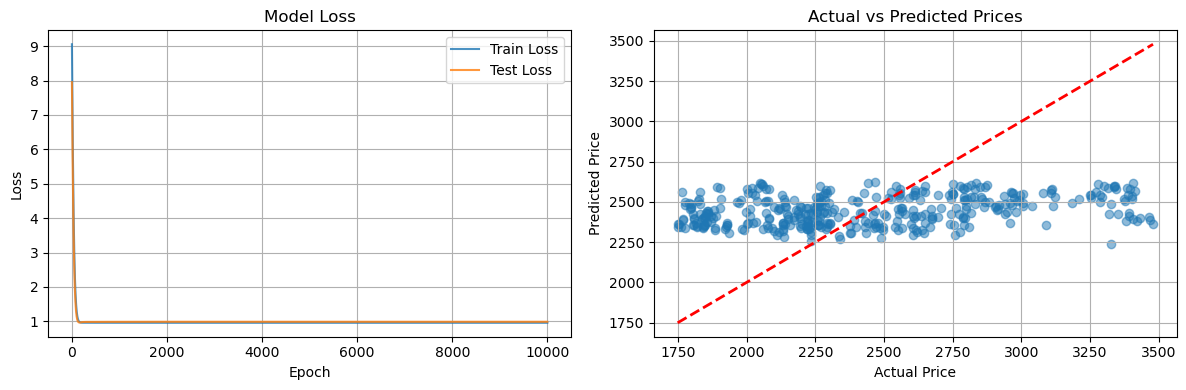

In [12]:
# 7. 학습 곡선 시각화
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', alpha=0.8)
plt.plot(test_losses, label='Test Loss', alpha=0.8)
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(y_test, test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.grid(True)

plt.tight_layout()
plt.show()

In [13]:
# 8. 모델 저장 - TensorFlow Checkpoint 형식
print("\n모델 저장 중")

# 저장 디렉토리 생성
save_dir = './model'
os.makedirs(save_dir, exist_ok=True)

# 체크포인트 객체 생성
checkpoint = tf.train.Checkpoint(W=W, b=b)

# 체크포인트 매니저 생성 (최대 3개의 체크포인트 유지)
checkpoint_manager = tf.train.CheckpointManager(
    checkpoint, save_dir, max_to_keep=3
)

# 체크포인트 저장
save_path = checkpoint_manager.save()
print(f"체크포인트가 저장되었습니다: {save_path}")

# 추가로 간단한 이름으로도 저장 
simple_checkpoint = tf.train.Checkpoint(W=W, b=b)
simple_save_path = simple_checkpoint.save(os.path.join(save_dir, 'saved.ckpt'))
print(f"추가 체크포인트 저장: {simple_save_path}")

# 체크포인트 파일 확인
print("\n저장된 파일:")
for file in os.listdir(save_dir):
    print(f"  - {file}")


모델 저장 중
체크포인트가 저장되었습니다: ./model\ckpt-1
추가 체크포인트 저장: ./model\saved.ckpt-1

저장된 파일:
  - checkpoint
  - ckpt-1.data-00000-of-00001
  - ckpt-1.index
  - saved.ckpt-1.data-00000-of-00001
  - saved.ckpt-1.index


In [14]:
# 9. 스케일러 저장 
scaler_X_path = os.path.join(save_dir, 'scaler_X.pkl')
scaler_y_path = os.path.join(save_dir, 'scaler_y.pkl')

joblib.dump(scaler_X, scaler_X_path)
joblib.dump(scaler_y, scaler_y_path)
print("\n스케일러가 저장되었습니다.")
print(f"  - {scaler_X_path}")
print(f"  - {scaler_y_path}")


스케일러가 저장되었습니다.
  - ./model\scaler_X.pkl
  - ./model\scaler_y.pkl


In [ ]:
# 10. 모델 테스트 (저장된 모델 로드 확인)
print("\n저장된 모델 로드 테스트")

# 새로운 변수로 로드
W_loaded = tf.Variable(tf.random.normal([4, 1], dtype=tf.float64), name="weight_loaded")
b_loaded = tf.Variable(tf.random.normal([1], dtype=tf.float64), name="bias_loaded")

# 체크포인트 복원
checkpoint_loaded = tf.train.Checkpoint(W=W_loaded, b=b_loaded)

# 최신 체크포인트 찾기
latest_checkpoint = tf.train.latest_checkpoint(save_dir)
print(f"최신 체크포인트: {latest_checkpoint}")

if latest_checkpoint:
    # 체크포인트 복원
    status = checkpoint_loaded.restore(latest_checkpoint)
    # expect_partial()을 사용하여 일부만 복원되어도 에러가 발생하지 않도록 함
    status.expect_partial()
    print(f"체크포인트 로드 완료")
else:
    print("체크포인트를 찾을 수 없습니다")

# 로드된 모델로 예측
def hypothesis_loaded(X):
    return tf.matmul(X, W_loaded) + b_loaded

# 샘플 예측
sample_data = np.array([[20.5, 15.0, 26.0, 50.0]], dtype=np.float64)
print(f"\n샘플 날씨 조건:")
print(f"  평균 기온: {sample_data[0][0]}°C")
print(f"  최저 기온: {sample_data[0][1]}°C")
print(f"  최고 기온: {sample_data[0][2]}°C")
print(f"  강수량: {sample_data[0][3]}mm")

sample_scaled = scaler_X.transform(sample_data)
prediction_scaled = hypothesis_loaded(sample_scaled).numpy()
prediction = scaler_y.inverse_transform(prediction_scaled)

print(f"\n예측 가격: {prediction[0][0]:.2f}원")

# 원본 모델과 로드된 모델 비교
original_pred = hypothesis(sample_scaled).numpy()
original_price = scaler_y.inverse_transform(original_pred)
print(f"원본 모델 예측: {original_price[0][0]:.2f}원")
print(f"차이: {abs(prediction[0][0] - original_price[0][0]):.2f}원")

print("\n모델 학습 및 저장이 완료되었습니다!")